# Week 4: Unsupervised learning: clustering

**Group:** CCTS<br>

**Members**:
   + Chiara Maccani (2027591)
   + Samuele Piccinelli (2027650)
   + Tommaso Stentella (2027586)
   + Cristina Venturini (2022461)

# Introduction

The goal of this notebook is to visualize $2$ different high dimensionality datasets through **t-SNE**, perform clustering with **DBSCAN** and test some of its hyper-parameters and functionalities.

We import useful libraries and dependecies:

In [1]:
import warnings
from time import time

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.colors import ListedColormap
plt.rc('font',**{'size':16, 'family':'serif'})
plt.rc('mathtext', **{'fontset':'cm'})

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from itertools import cycle, islice
from collections import OrderedDict


%matplotlib inline
np.random.seed(0)

# 1. First dataset

We import the first dataset `data_t-SNE_310101_d5_R100_e1_N800.dat` composed embedded manifolds, which represent three clusters with a linear closed structure. Given $N=800$ data points, the first $10\%$ belongs to cluster $0$ (red), the next $30\%$ to cluster $1$ (green) and the last $60\%$ to cluster $2$ (blue).<br>
For this case in $d=5$ we define a **dataframe** `data` with each column holding a dimension, while the last column `y` holds the labels.

Furthermore, we define another dataframe `X` holding the features alone which are normalized with mean $0$ and unitary standard deviation through the `StandardScaler()` function of `scipy`.

In [2]:
data = pd.read_csv('DATA/data_t-SNE_310101_d5_R100_e1_N800.dat', sep='\t', names=['x1','x2','x3','x4','x5'])

In [3]:
cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC",
            "#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601",
            "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375",
            "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F", "lightgray"]
mycol = ['k', 'r', 'g', 'b', 'y']
cmap = ListedColormap(mycol)

In [4]:
N = len(data)
y_true = np.concatenate((np.full(int(N*.1),0),np.full(int(N*.3),1),np.full(int(N*.6),2)))
data['y'] = y_true
X = data[['x1','x2','x3','x4','x5']]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=['x1','x2','x3','x4','x5'])
red, green, blue = y_true == 0, y_true == 1, y_true == 2

display(X.head())

x1        x2        x3        x4        x5
0 -1.212180  0.017043  0.812589 -1.496157 -0.428825
1 -1.708039  0.174829  0.807032 -1.770696 -0.986126
2 -1.318546  0.050212  0.819328 -1.615018 -0.457749
3 -1.507685  0.073520  0.864493 -1.733311 -0.740321
4 -1.105868  0.015469  0.726256 -1.414591 -0.389050

The graph below shows the *unnormalized* data, projected in the first $3$ dimensions $x_1,x_2,x_3$; each color is given by the corresponding label.

In [5]:
# to visualize plotly library is needed
x = data[['x1']].to_numpy().flatten()
y = data[['x2']].to_numpy().flatten()
z = data[['x3']].to_numpy().flatten()
labels = data[['y']].to_numpy().flatten()

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=3, color=labels, opacity=0.8))])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

# 2. t-SNE Algorithm

We apply here t-SNE with $3$ different perplexities to the data; the algorithm can be initialized by using principal component analysis (PCA).

As for what concerns initialization, after some research we have found two articles talking about it [1][2]; these articles concern specific applications of t-SNE to single-cell transcriptomics, but the considerations on PCA/random initialization can be generalized. 
The advantage in using PCA initialization (which is an informative initialisation) is that it preserves global structure. This injects the global structure into the t-SNE embedding which is then preserved during the course of t-SNE optimisation while the algorithm optimises the fine structure. PCA initialisation is also convenient because it makes the t-SNE outcome reproducible and not dependent on a random seed. [1]


[1] Kobak, D., Berens, P. The art of using t-SNE for single-cell transcriptomics. Nat Commun 10, 5416 (2019). https://doi.org/10.1038/s41467-019-13056-x

[2] Becht, E., McInnes, L., Healy, J. et al. Dimensionality reduction for visualizing single-cell data using UMAP. Nat Biotechnol 37, 38–44 (2019). https://doi.org/10.1038/nbt.4314

random initialization, perplexity = 5 in 13 sec; Kullback-Leibler divergence after optimization: 0.2680
pca initialization, perplexity = 5 in 4.4 sec; Kullback-Leibler divergence after optimization: 0.2492
random initialization, perplexity = 30 in 5.9 sec; Kullback-Leibler divergence after optimization: 0.2526
pca initialization, perplexity = 30 in 2.9 sec; Kullback-Leibler divergence after optimization: 0.2384
random initialization, perplexity = 100 in 9.6 sec; Kullback-Leibler divergence after optimization: 0.2703
pca initialization, perplexity = 100 in 12 sec; Kullback-Leibler divergence after optimization: 0.2718


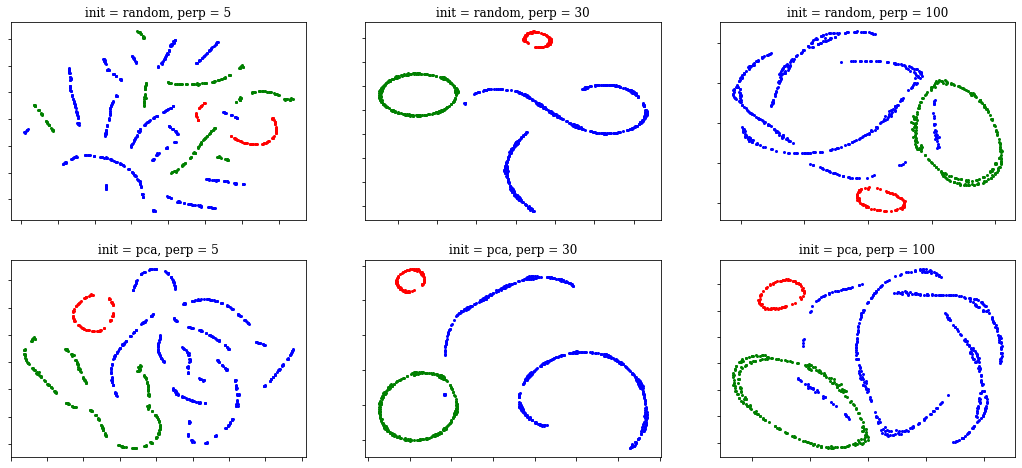

In [6]:
perplexities = [5,30,100]
initialization = ['random','pca']
n_components = 2

(fig, subplots) = plt.subplots(len(initialization), len(perplexities), figsize=(18, 8))

for i, perplexity in enumerate(perplexities):
    for j in range(len(initialization)):
        ax = subplots[j][i]

        t0 = time()
        tsne = TSNE(n_components=n_components, init=initialization[j],
                    random_state=0, perplexity=perplexity)
        Y = tsne.fit_transform(X)
        t1 = time()
        print('%s initialization, perplexity = %d in %.2g sec; Kullback-Leibler divergence after optimization: %.4f'
              % (initialization[j], perplexity, t1 - t0, tsne.kl_divergence_))
        ax.set_title("init = %s, perp = %d" % (initialization[j],perplexity))
        ax.scatter(Y[red, 0], Y[red, 1], c="r", s=4)
        ax.scatter(Y[green, 0], Y[green, 1], c="g", s=4)
        ax.scatter(Y[blue, 0], Y[blue, 1], c="b", s=4)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

# 3. DBSCAN Algorithm for Clustering

We analyze the clustering in $d=5$ dimensions: the goal here is to generate a set of predicted labels and then plot the results.<br>
To understand a good range for the cutoffs `eps` in DBSCAN, we sort in ascending order the minimum distances to the $n-th$ nearest neighbor and plot them. For this part we refer to the works in [3] and [4]. In the latter, for any given $k\leq1$ the authors define a function k-distance, mapping each object to the distance from its $k^{th}$ nearest neighbor (the parameter `n_neighbors` in the code below). The suggestion is to set $k=2d-1$ with $d$ being the dimension of the dataset.<br>
The ideal value for $\varepsilon$ would be then equal to the distance value at the “crook of the elbow”, i.e. the point of maximum curvature in the nearest neighbor graph. In oder to find it we calculate the slopes $\frac{y_{n}-y_{n-1}}{x_{n}-x_{n-1}}$ in `slopes` and subsequently evaluate the percentage difference for each couple in the vector. The best value for $\varepsilon$ is given by the corresponding ordinate on the graph, showed by the black dashed line in the plot below.

[3] https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf <br>
[4] https://link.springer.com/content/pdf/10.1023/A:1009745219419.pdf

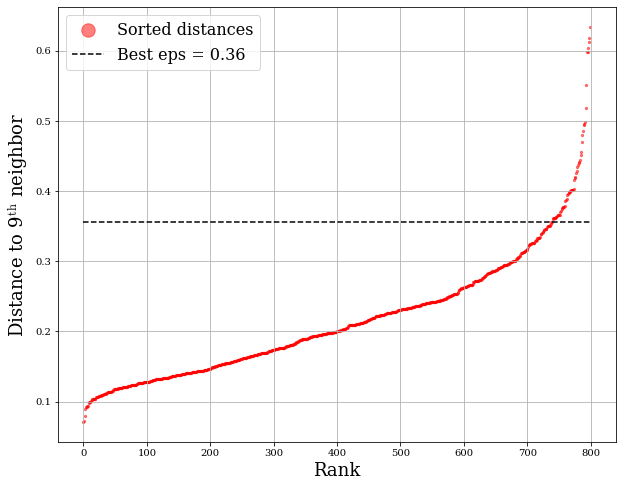

In [7]:
n_neighbors = 9
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='l2').fit(X)
distances, indices = nbrs.kneighbors(X)
x, y = indices[:,0], np.sort(distances[:,-1]) #np.sort(distances[:,1:].mean(axis=1))

def get_perc(current, previous):
    if current == previous: return 0
    return (np.abs(current - previous) / previous)*100 if previous != 0 else 0

slopes = np.array([(y[i] - y[i-1]) for i in range(1,N)])
percentage = np.array([get_perc(slopes[i], slopes[i-1]) for i in range(1,len(slopes))])
best_eps = y[np.where(percentage==percentage.max())]

plt.figure(figsize=(10,8))
plt.scatter(x, y, s=5, alpha=.5, color='r', label='Sorted distances')
plt.hlines(best_eps, 0, N, colors='k', linestyle='dashed', label=r'Best eps = %.2f' % best_eps)
plt.xlabel('Rank', size=18)
plt.ylabel(r'Distance to %s$^{\mathrm{th}}$ neighbor' % n_neighbors, size=18)
plt.legend(prop={'size': 16},markerscale=6)
plt.grid(True)
plt.show()

In [8]:
def NMI(y_true, y_pred):
    # Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

In the plot below `minPts` is set to $k+1$ as suggested by the cited literature; the parameter `Nc` is the number of clusters found by the algorithm.

The value of `nmi` quantifies the difference between true and predicted labels, i.e. $1.00$ stands for a $100\%$ accuracy. The unclassified points are shown in light-grey.

In [9]:
def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        if yu == -1: ax.scatter(X[pos]['x1'], X[pos]['x2'],c=cpalette[-1], cmap=cmap,s=4)
        else: ax.scatter(X[pos]['x1'], X[pos]['x2'],c=cpalette[i%len(cpalette)], cmap=cmap,s=4)
            
def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

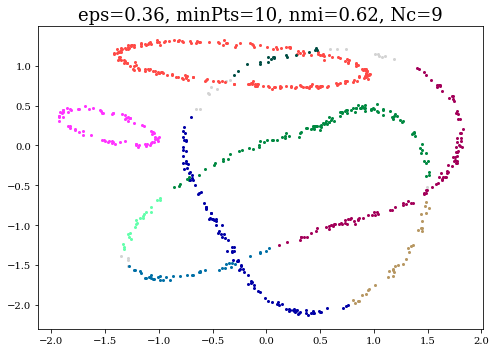

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
model = DBSCAN(eps=best_eps, min_samples=n_neighbors+1)
model.fit(X)
y = model.labels_
plotting_ax(X,y,ax)
nmi=NMI(y, y_true)
if bool(set(np.unique(y)) & set([-1])): nc = len(np.unique(y))-1
else: nc = len(np.unique(y))
ax.set_title('eps=%.2f, minPts=%i, nmi=%.2f, Nc=%i'%(best_eps,n_neighbors+1,nmi,nc), size=18)
plt.tight_layout(h_pad=1.5)
plt.show()

The method used above requires to fix the value of `minPts` and based on that to look for the optimal value of `eps`.<br>
However, in our case the performance is very poor and so we tried to change also the value of `minPts` in order to find the best combination, fixing the value of `eps` and `minPts`.

We show the results below in a grid respectively by row and by column. The color convention is the same as seen before.

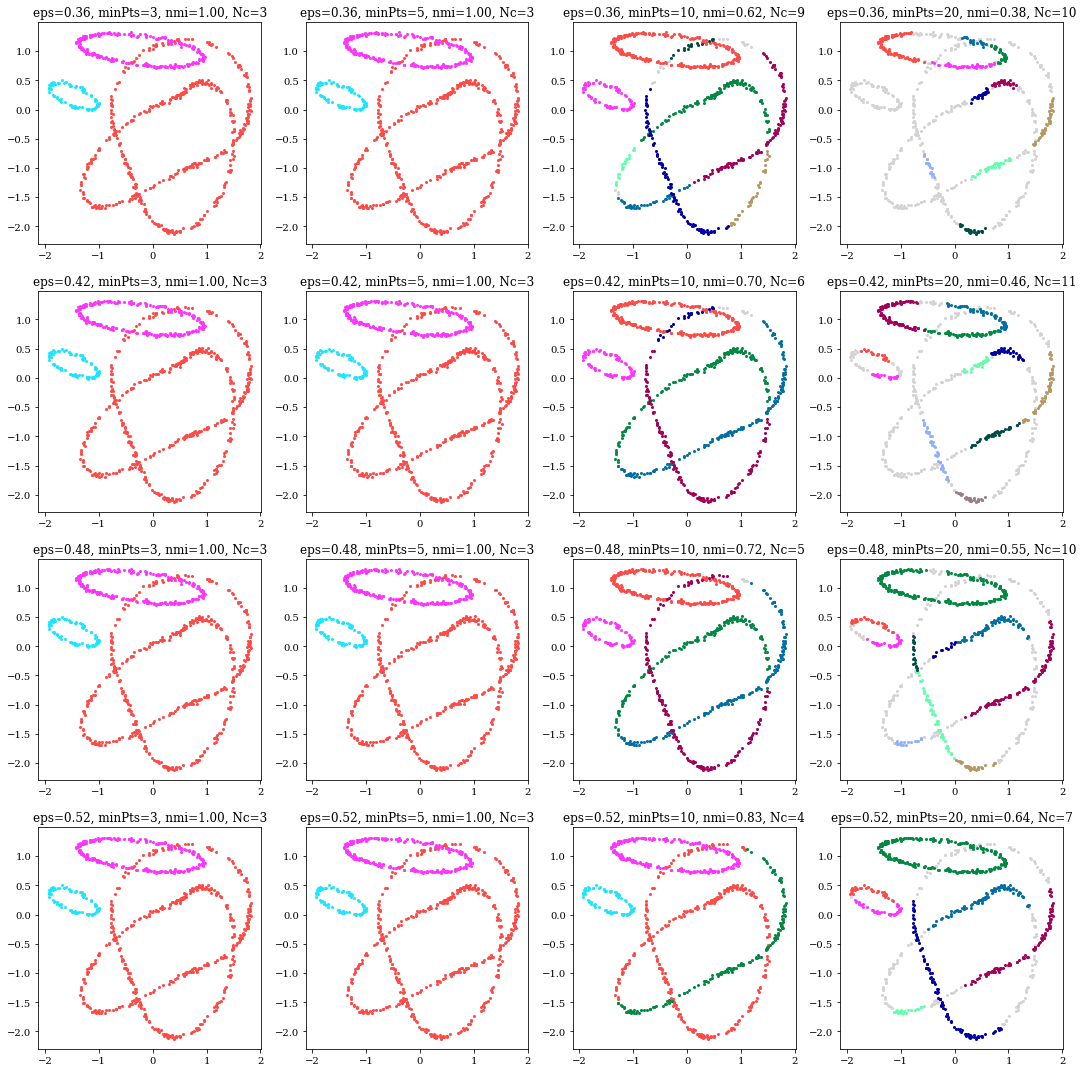

In [11]:
eps_range = [best_eps,0.42,0.48,0.52]
min_sample_range = [3,5,10,20]

fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,15))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        plotting_ax(X,y,ax[i,j])
        nmi=NMI(y, y_true)
        if bool(set(np.unique(y)) & set([-1])): nc = len(np.unique(y))-1
        else: nc = len(np.unique(y))
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f, Nc=%i'%(eps,min_samples,nmi,nc))
plt.tight_layout(h_pad=1.5)
plt.show()

As one can observe from the plots above, for a value of `minPts` of $3$ and $5$ the clustering reaches $100\%$ accuracy with a value of $\varepsilon \in [0.38, 0.52]$. To reach this value of accuracy we actually had to set the values of the parameters in a way that was in contrast with the literature mentioned above: the clustering works better for lower values of `minPts` and higher values of `eps` than expected. This may be due to the knotted structure of the red cluster that overlaps with the pink one and thus challenges the convergence of DBscan.

Notice how there is a range of values for the `eps` parameter that yields to the same clustering: this is because _"not all objects of the “thinnest” cluster need to be core objects. They may also belong to the cluster if they are only density-reachable. Furthermore, the Eps value may be larger than needed if the clusters are well separated and the density of noise is clearly lower than the density of the thinnest cluster_ [4].

Lastly, for comparison, we show below a plot with all minimum distances sorted to first neighbors.

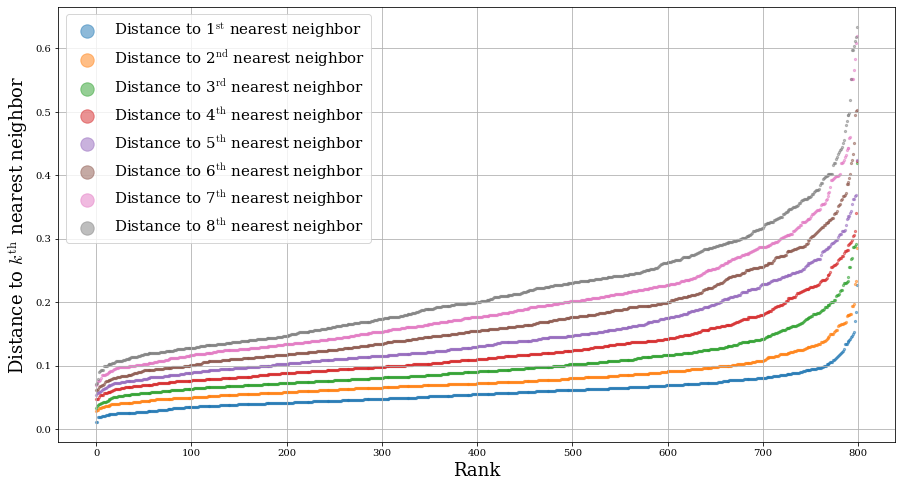

In [12]:
order = ['st','nd','rd'] + (n_neighbors-4)*['th']
plt.figure(figsize=(15,8))
for i, ordr in enumerate(order):
    x, y = indices[:,0], np.sort(distances[:,i+1])
    plt.scatter(x, y, s=5, alpha=.5, label=r'Distance to %i$^{\mathrm{%s}}$ nearest neighbor' % (i+1,ordr))
    plt.xlabel('Rank', size=18)
    plt.ylabel(r'Distance to $k^{\mathrm{th}}$ nearest neighbor', size=18)
    plt.legend(prop={'size': 15},markerscale=6)
plt.grid(True)
plt.show()

# 4. Second dataset

First of all the files containing the data and the labels are loaded. The dataset is composed by $N=400$ sequences of lenght $L=36$ formed by bits $0$ or bits $1$ generated uniformly. For each of those, some bits are overwritten following a pattern chosen through a uniform distribution from a set of $5$. Each sample is, in this way, labelled with the number corresponding to the pattern injected $y=\{0,1,2,3,4\}$.

The aim of this analysis, performed by applying the DBSCAN algorithm, is to find the clustering model that groups the data in the best way.

In [13]:
x2 = np.loadtxt('DATA/x_M5_N400.csv', delimiter=' ')
y2 = np.loadtxt('DATA/y_M5_N400.csv', delimiter=' ')

N = len(x2)
L = len(x2[0])
print("N =", N)
print("L =", L)

N = 400
L = 36


In order to have a visual understanding of how the generated data are grouped, a t-SNE transformation is performed reducing the number of dimensions from $L=36$ to $L'=2$. The figure below shows the scatterplots of the 2-dimensional data transformed by fixing different values of the perplexity parameter and changing the type of inizialization of the t-SNE algorithm (random or PCA).

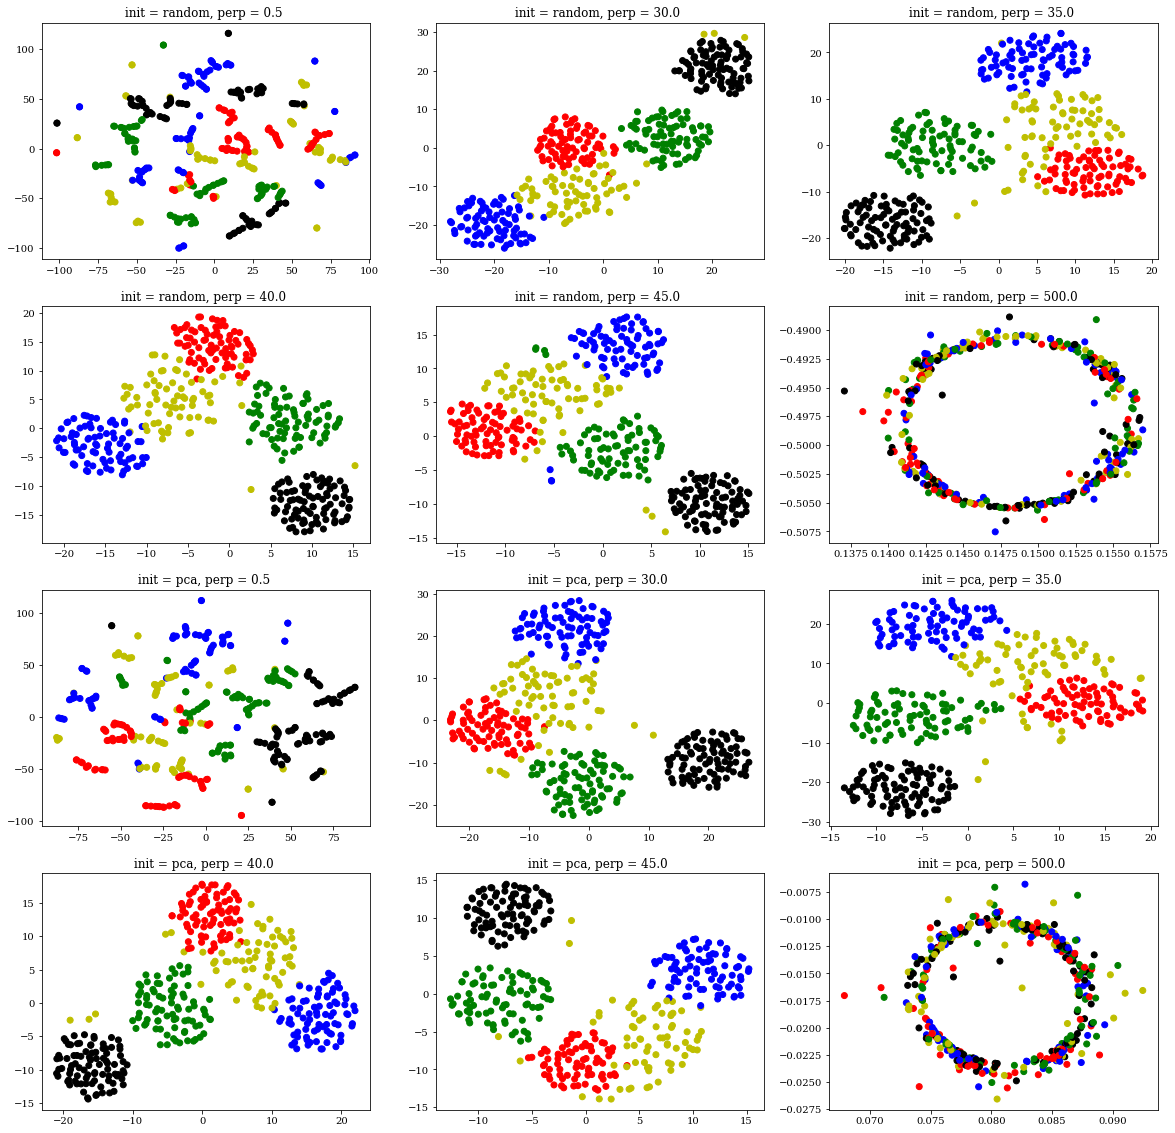

In [14]:
np.random.seed(12345)

perplexity = [0.5, 30, 35, 40, 45, 500]
init = ['random', 'pca']

mycol = ['k', 'r', 'g', 'b', 'y']
cmap = ListedColormap(mycol)

ax = []
fig = plt.figure(figsize=(20,20))
for i in range(len(init)):
    for j in range(len(perplexity)):
        ax.append(1)
        x2_emb = TSNE(n_components=2, perplexity=perplexity[j], init=init[i]).fit_transform(x2)

        ax[i*len(perplexity)+j] = fig.add_subplot(4, 3, i*len(perplexity)+j+1)
        ax[i*len(perplexity)+j].scatter(x=x2_emb[:,0], y=x2_emb[:,1], c=y2, cmap=cmap)
        ax[i*len(perplexity)+j].set_title('init = %s, perp = %.1f '%(init[i],perplexity[j]))
plt.show()

It can be seen that the optimal range for perplexity is around a few tens, in fact for the extreme values the cluster structure is not conserved.<br>
For intermediate values of perplexity, for each inizialization parameter it can be observed that the samples associated to label $y=0,2,3$ (black, green and blue) are usually well grouped, while points labelled as $y=2$ (yellow) are always more spread in the 2-dimensional space. Also, they are always very close to samples labelled as $y=1$ (red).<br>
There's no improvment in using PCA initialization instead of the random one because the original data are only slightly correlated.

For the following analysis we fix the perplexity to $40$ and use PCA as initialization algorithm.

In [15]:
np.random.seed(12345)
x2_emb = TSNE(n_components=2, perplexity=40, init='pca').fit_transform(x2)

Here we compute the distance between clusters in the 36-dimensional space as the distance between the mean position of the samples belonging to each class, using the L1-norm (since the sequences are composed by bits).

In [16]:
avg_dist = np.array([[np.sum(np.abs(x2[y2==i].sum(0)/len(x2[y2==i]) - x2[y2==j].sum(0)/len(x2[y2==j])))
                      for i in range(5)] for j in range(5)])

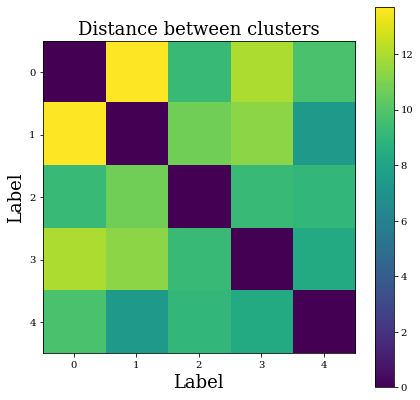

In [17]:
plt.figure(figsize=(7,7))
plt.imshow(avg_dist)
plt.colorbar()
plt.xlabel("Label", size=18)
plt.ylabel("Label", size=18)
plt.title("Distance between clusters", size=18)
plt.show()

It can be seen that indeed clusters $1$ and $4$ (the red and the yellow one respectively in the scatterplots above) are closest in the initial space and t-SNE keeps them so in the final one.

For each point we then calculated the minimum L1-distance to its first neighbor. The sorted values are visible in the plot below. 

In [18]:
min_dist = np.array([[np.sum(np.abs(x2[i]-x2[j])) for j in range(N)] for i in range(N)])
min_dist = np.sort(min_dist[min_dist != 0].reshape(N, N-1).min(1))

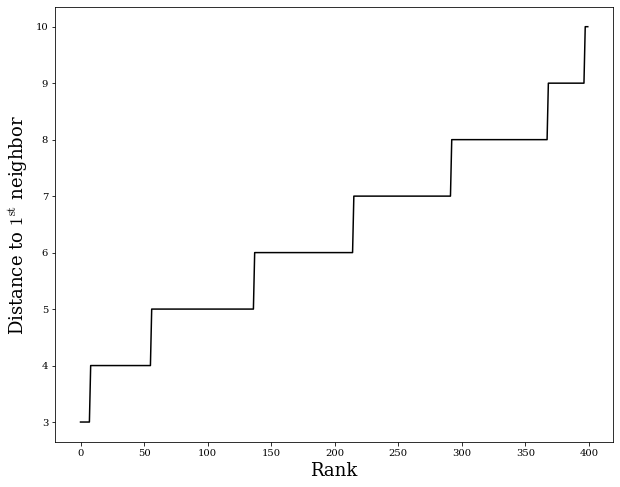

In [19]:
plt.figure(figsize=(10,8))
plt.plot([i for i in range(N)], min_dist, color='k')
plt.xlabel("Rank", size=18)
plt.ylabel("Distance to $1^{\mathrm{st}}$ neighbor", size=18)
plt.show()

We will use this plot to choose a reasonable value of the $\varepsilon$ parameter of the DBSCAN algorithm.

# 5. DBSCAN

## 5.1 DBSCAN applied to the 36-dim space

In order to find the best clustering model the DBSCAN algorithm is applied several times varying the parameter $\varepsilon$ in a range between $3$ and $10$ and varying `minPts` in a range between $3$ and $15$. The L1-metric is used.<br>
Since in this case the real labels are known, it is possible to compute the normalized mutual entropy (NMI) that can give a measure of the goodness of the predictor. The more this quantity is close to $1$ the more the model is able to correctly classify the samples.

In the following plots we report the results projected in the 2-dimensional space using the t-SNE transformation described in the previous section.

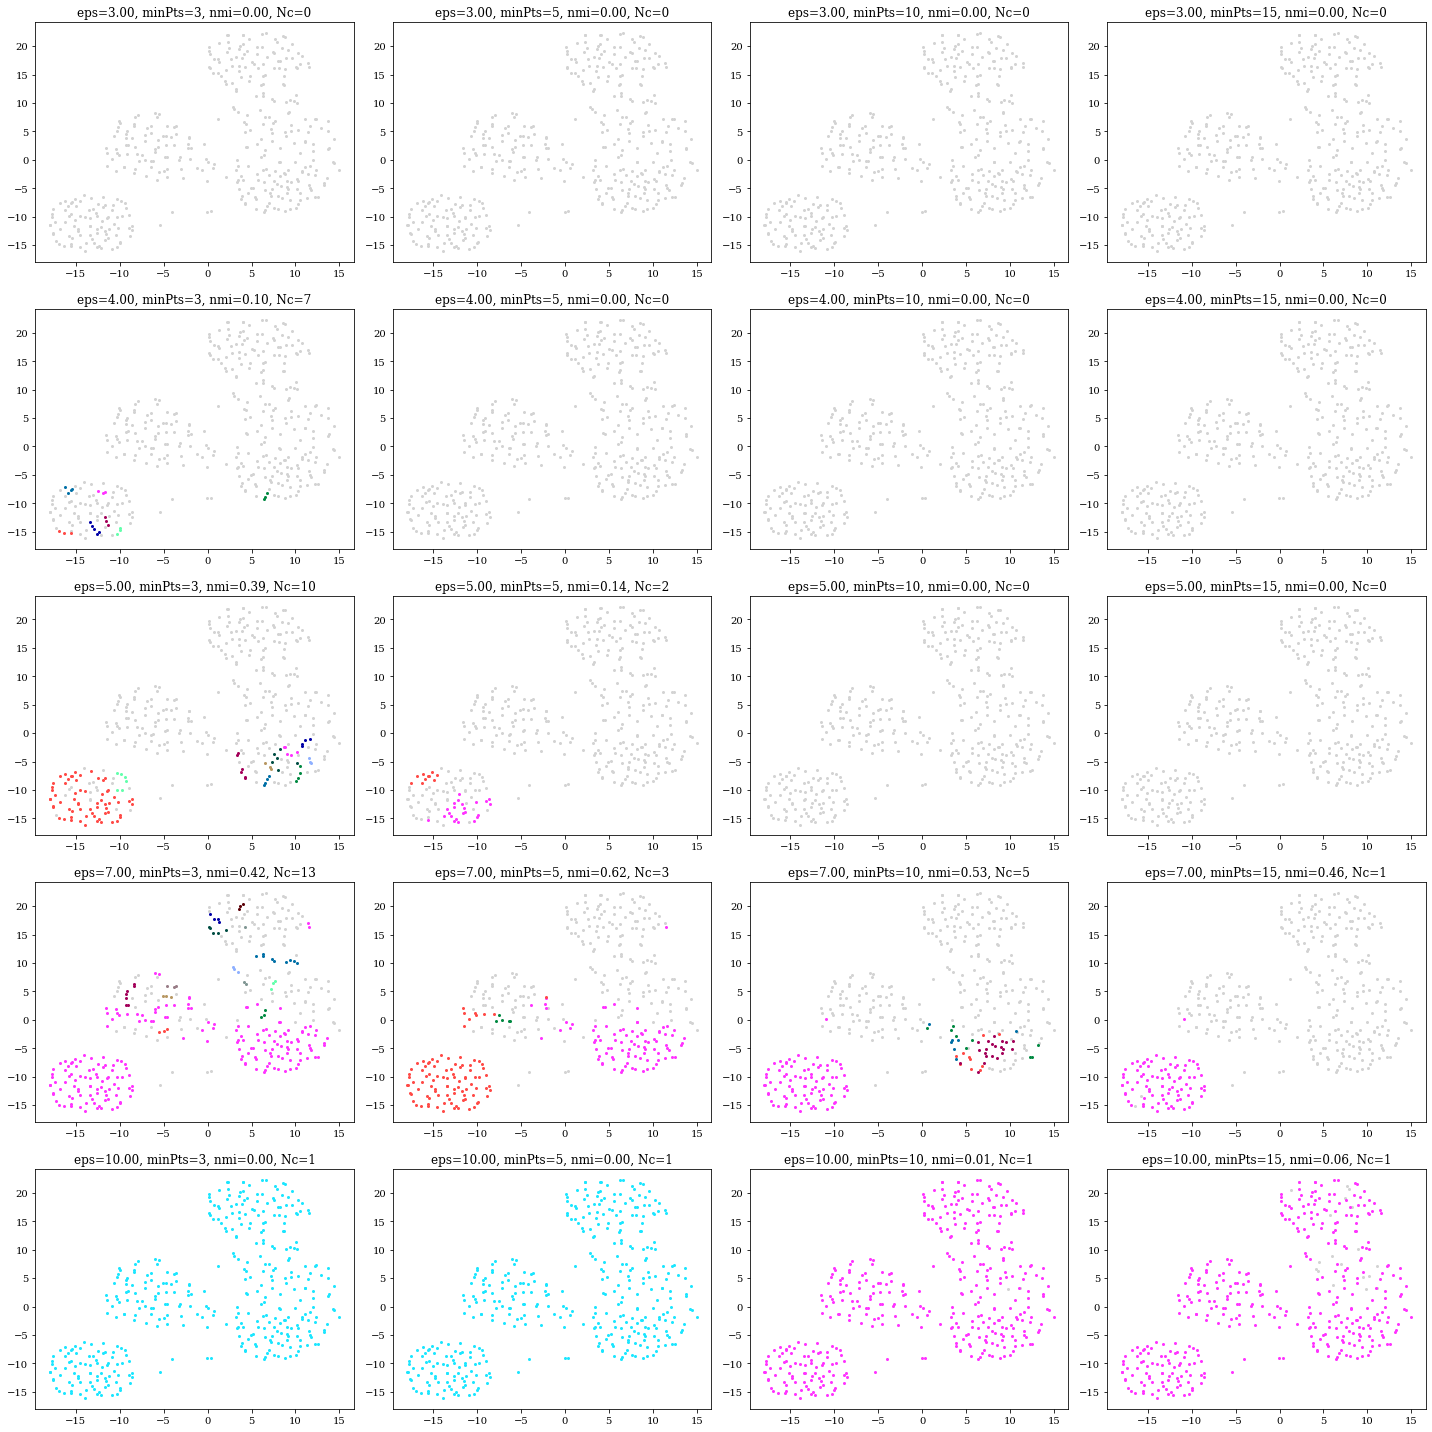

In [20]:
def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        if yu == -1:
            ax.scatter(X[pos,0], X[pos,1],c=cpalette[-1], cmap=cmap,s=4)
        else:
            ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)], cmap=cmap,s=4)

X, ytrue = x2, y2
eps_range = [3.,4.,5.,7.,10.]
min_sample_range = [3, 5,10,15]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(20,20))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='l1')
        model.fit(X)
        y = model.labels_
        plotting_ax(x2_emb,y,ax[i,j])
        nmi=NMI(y, ytrue)
        if bool(set(np.unique(y)) & set([-1])): nc = len(np.unique(y))-1
        else: nc = len(np.unique(y))
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f, Nc=%i'%(eps,min_samples,nmi,nc))
plt.tight_layout(h_pad=1.5)
plt.show()

It can be oserved that in most cases the algorithm fails in finding any cluster (as before, the light-grey color is associated to the non classified points); in the case of big parameters it groups all the samples in a single cluster.

The whole analysis is repeated using the euclidean metric. However, this change doesn't lead to any relevant improvement.

In [21]:
min_dist_eucl = np.array([[np.sqrt(np.sum((x2[i]-x2[j])**2)) for j in range(N)] for i in range(N)])
min_dist_eucl = np.sort(min_dist_eucl[min_dist_eucl != 0].reshape(N, N-1).min(1))

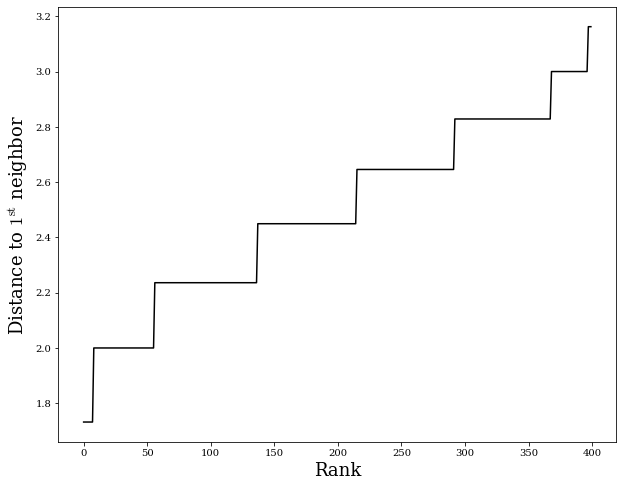

In [22]:
plt.figure(figsize=(10,8))
plt.plot([i for i in range(N)], min_dist_eucl, color='k')
plt.xlabel("Rank", size=18)
plt.ylabel("Distance to $1^{\mathrm{st}}$ neighbor", size=18)
plt.show()

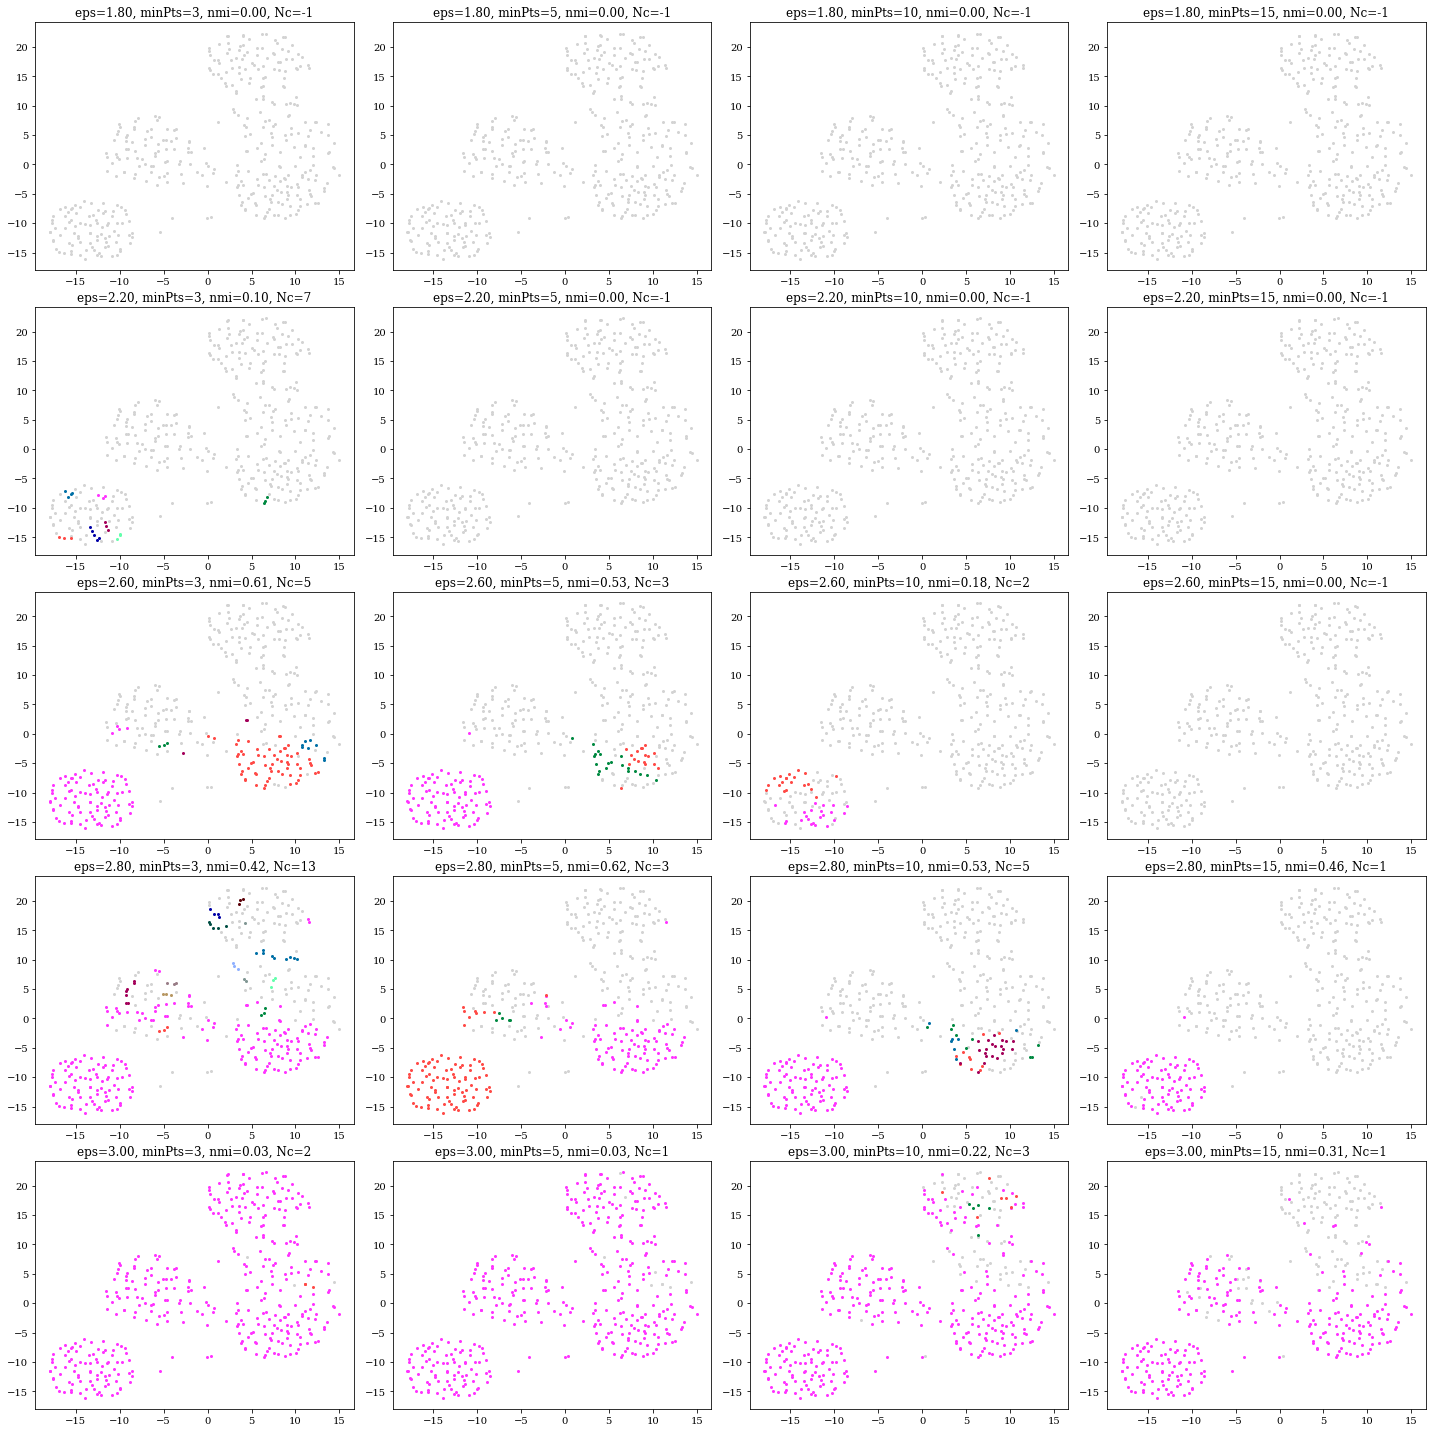

In [23]:
X, ytrue = x2, y2

eps_range = [1.8,2.2,2.6,2.8,3.]
min_sample_range = [3, 5,10,15]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(20,20))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        model.fit(X)
        y = model.labels_
        plotting_ax(x2_emb,y,ax[i,j])
        nmi=NMI(y, ytrue)
        if len(np.unique(y))==1:
            nc = -1
        else:
            nc = len(np.unique(y))-1
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f, Nc=%i'%(eps,min_samples,nmi,nc))
plt.tight_layout(h_pad=0.5)
plt.show()

## 5.2. DBSCAN applied to the 2-dim space

Finally, we try to apply the DBSCAN algorithm directly to the 2-dimensional transformed data using the euclidian metric. The analysis is repeated in the same way as before.

In [24]:
min_dist_emb = np.array([[np.sqrt(np.sum((x2_emb[i]-x2_emb[j])**2)) for j in range(N)] for i in range(N)])
min_dist_emb = np.sort(min_dist_emb[min_dist_emb != 0].reshape(N, N-1).min(1))

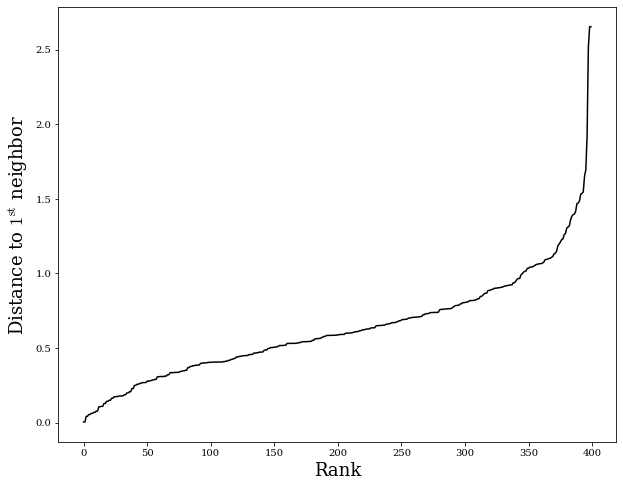

In [25]:
plt.figure(figsize=(10,8))
plt.plot([i for i in range(N)], min_dist_emb, color='k')
plt.xlabel("Rank", size=18)
plt.ylabel("Distance to $1^{\mathrm{st}}$ neighbor", size=18)
plt.show()

By observing the plot above a new $\varepsilon$ range is chosen in order to be suitable to this new problem.

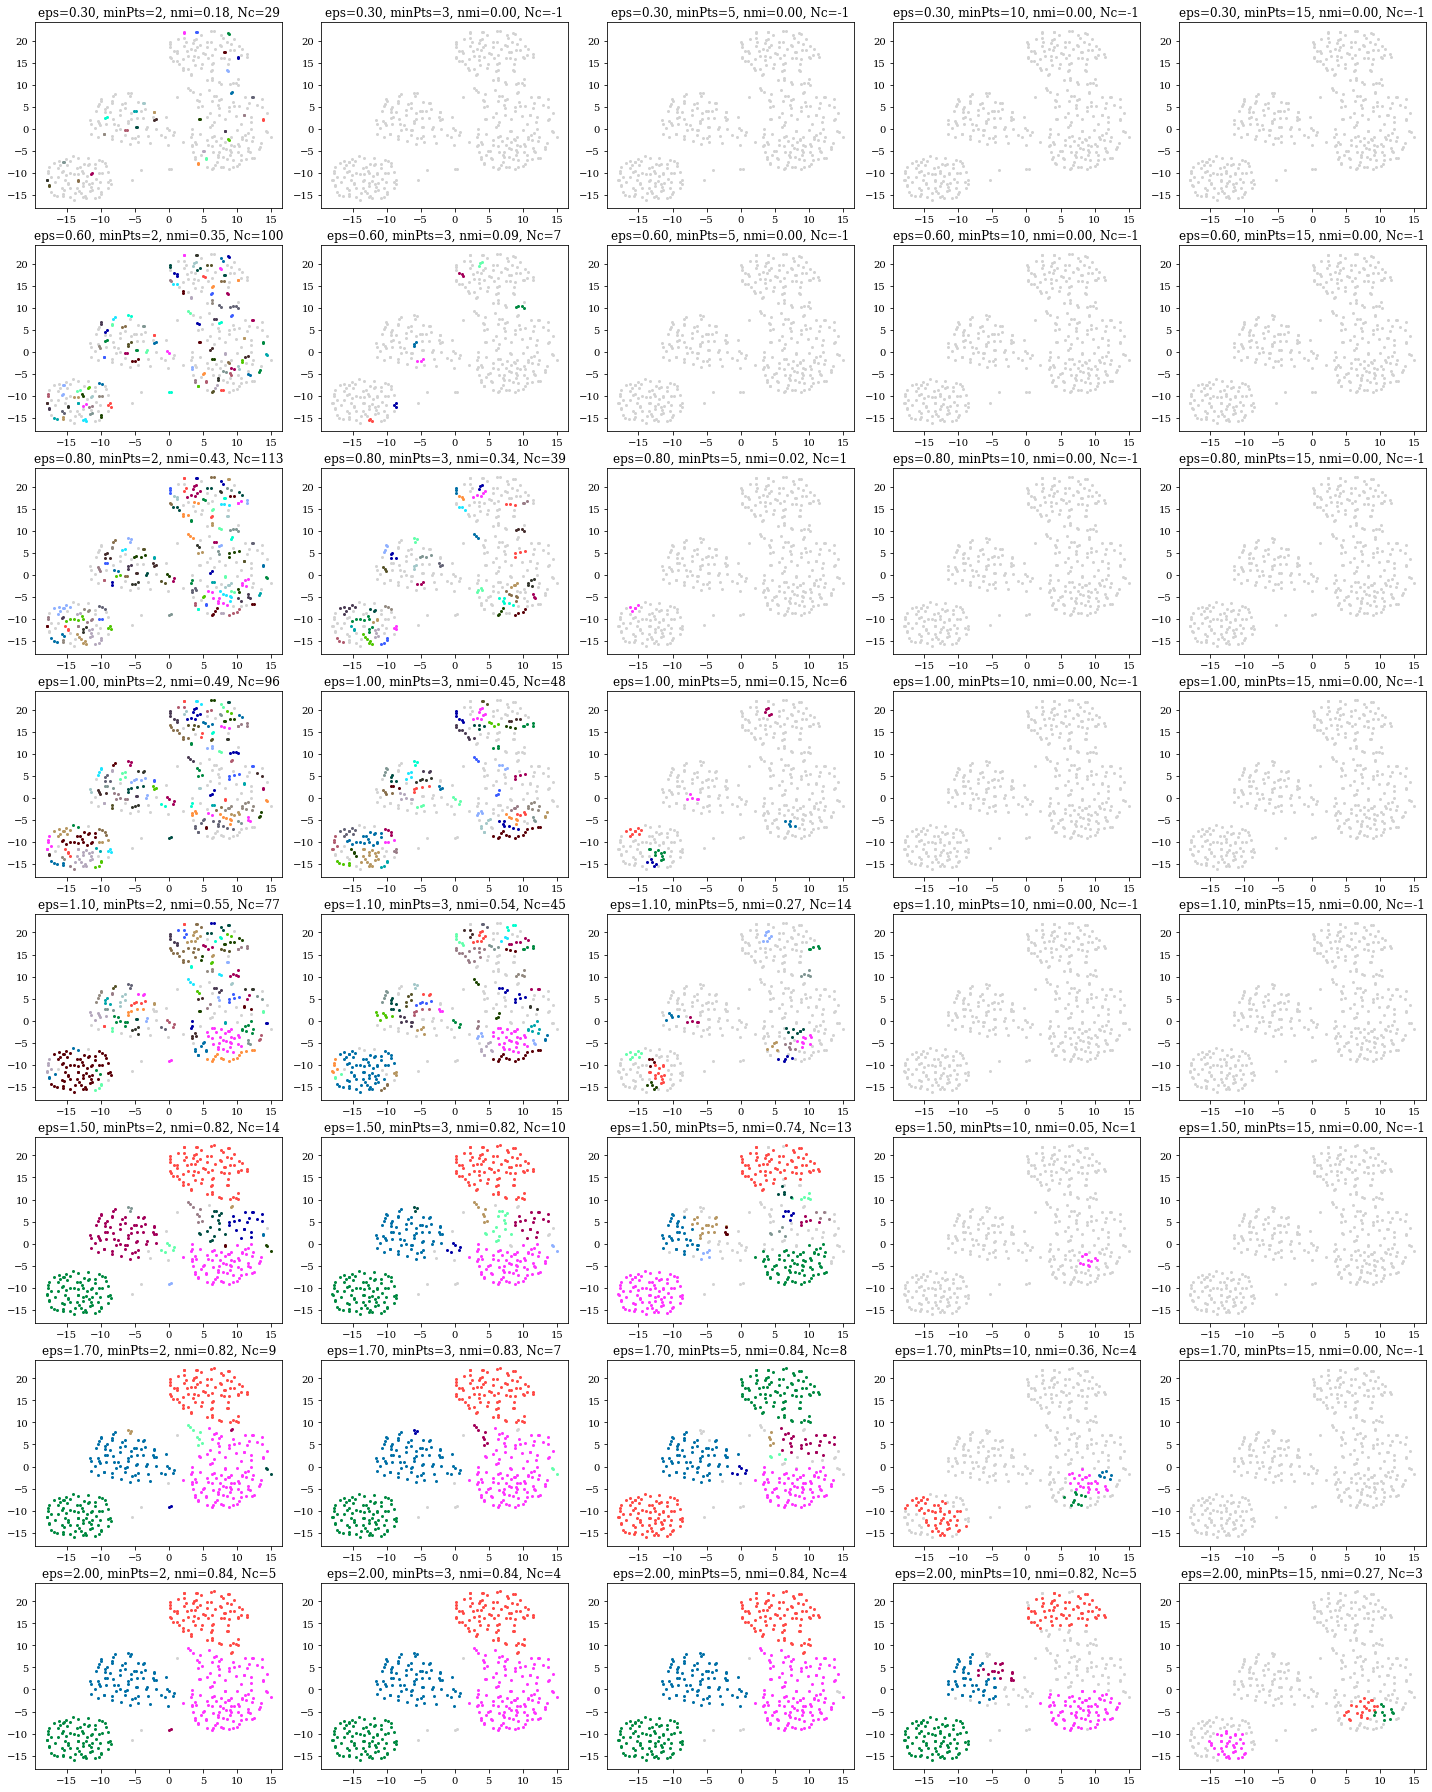

In [26]:
X, ytrue = x2_emb, y2

eps_range = [.3,.6,.8,1.,1.1,1.5,1.7,2.0]
min_sample_range = [2,3,5,10,15]
dat = np.zeros((len(eps_range)*len(min_sample_range)))
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(20,25))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
        model.fit(X)
        y = model.labels_
        plotting_ax(X,y,ax[i,j])
        nmi=NMI(y, ytrue)
        if len(np.unique(y))==1:
            nc = -1
        else:
            nc = len(np.unique(y))-1
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f, Nc=%i'%(eps,min_samples,nmi,nc))
        dat[i*len(min_sample_range)+j] = nmi
plt.tight_layout(h_pad=0.5)
plt.show()

Many combinations of $\varepsilon$ and `minPts` are tested.<br>
The predictions of some models lead to values of $\text{NMI}>0.80$. Overall, the algorithm performs better in this case rather than when applied to the 36-dimensional data. We can see that for some values of the parameter it manages to recognize $3$ clusters in the right way and merges the other $2$ in a single one. The merged ones are the clusters that we previously noticed to be the closest.

In the following $3D$-plot we show the normalized mutual entropy as a funcion of the two parametrs $\varepsilon$ and `minPts`.

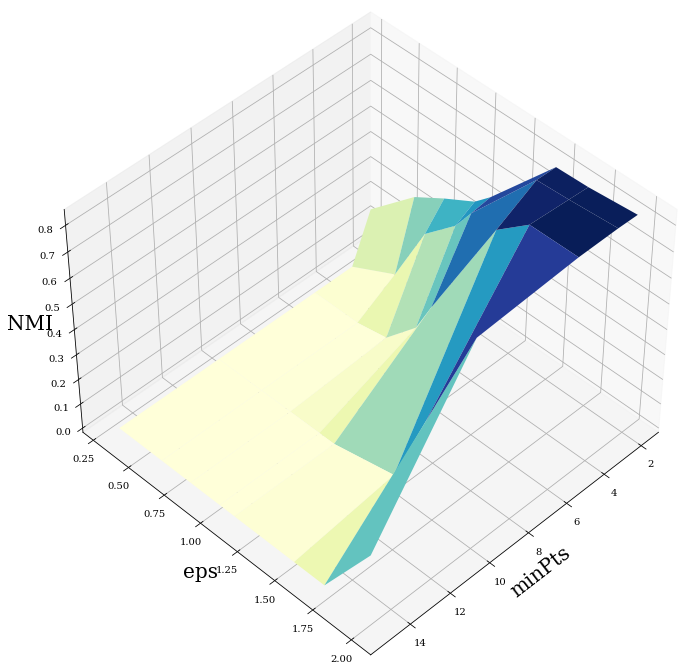

In [27]:
xs, ys = np.meshgrid(min_sample_range, eps_range)
zs = dat.reshape(8,5)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xs, ys, zs, cmap='YlGnBu')
ax.set_xlabel('minPts', size=20)
ax.set_ylabel('eps', size=20)
ax.set_zlabel('NMI', size=20)
ax.view_init(45, 45)
plt.show()

The original samples are binary so that in this space density (on which the clustering algorithm is based) is a strange notion.<br>
The samples could be represented as vertices of an $L$-dimensional unitary cube, or the $1/2^{L}$ fraction spaces (sort of multidimensional quadrants) defined by the $L$ axis. The regular and discrete nature of the data is reflected in the minimum distances between samples and consequently in the ability of the DBscan algorithm of propagating through the cluster.<br>
For example, if we had an hyper-cube with all the vertices occupied, the minimum distance between two points would be $1$ for each point and would guarantee that all the points end up in the same cluster.<br>
This case is more complicated: nevertheless, the set of possible distances is very limited and is not enough to have well separated clusters. In fact, by looking at the samples (or at how they are generated) one can see that they have common coordinates, so they do not exploit the whole variability given by the 36 dimensions.<br>
Mapping the data to a new $2$-dimensional space with t-SNE allows a magnification of the densities, resulting in better distinguishable clusters.